In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from keras.models import Sequential
from keras.layers import Bidirectional, Dense, Dropout, Embedding, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
master_df = pd.read_csv('data/features_nltk.csv')
df = master_df.copy()

# Word2Vec Embeddings

In [6]:
from gensim.models import Word2Vec

In [4]:
df['tokenized_text_nltk'] = df['tokenized_text_nltk'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",''))
df['tokenized_text_nltk'] = df['tokenized_text_nltk'].apply(lambda x: x.split())
sentences = df['tokenized_text_nltk'].tolist()

In [6]:
embed_size = 50
max_features = 20000
maxlen = 50
w2v_model = Word2Vec(sentences=sentences, vector_size=embed_size, window=5, min_count=1)

In [8]:
len(w2v_model.wv)

28337

In [7]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
tokenized_train = tokenizer.texts_to_sequences(sentences)

x = pad_sequences(tokenized_train, maxlen=maxlen)

In [10]:
vocab_size = len(w2v_model.wv) + 1 #for the zero-indexed unknown words

In [16]:
from itertools import chain
words = set(chain(*sentences))

In [14]:
glove_dict = {}
with open('embeddings/glove.6B.50d.txt') as f:
    for line in f:
        vec = line.split()
        word, vec = vec[0], list(map(float, vec[1:]))
        glove_dict[word] = np.array(vec)


In [18]:
glove_model = {}
for word in words:
    glove_model[word] = glove_dict.get(word, np.zeros(50))

In [19]:
def get_weight_mat(model, vocab):
    vocab_size = len(vocab) + 1 #for unknown words
    weights = np.zeros((vocab_size, embed_size))
    for word, i in vocab.items():
        weights[i] = model[word]
    return weights

# Baseline Models
| Model               | Acc                | F1                 | Precision          | Recall             |
|---------------------|--------------------|--------------------|--------------------|--------------------|
| Unidirectional LSTM | 0.7157306790351867 | 0.7161463260650635 | 0.6404480457305908 | 0.819377315044403  |
| Bidirectional LSTM  | 0.7386746406555176 | 0.7293523550033569 | 0.6689189076423645 | 0.8017902970314026 |
| Unidirectional GRU  | 0.7442905306816101 | 0.7013553977012634 | 0.7199282050132751 | 0.6837169528007507 |
| Bidirectional GRU   | 0.7439161539077759 | 0.708564043045044  | 0.7082623243331909 | 0.7088661789894104 |

Bi-directional LSTM appeared to demonstrate the best performance among all RNN models (Vanilla RNN was excluded from discussion)

## Unidirectional LSTM

In [20]:
embedding_vecs = get_weight_mat(w2v_model.wv, tokenizer.word_index)


In [11]:
def create_embeddings(embed_size, tokenizer):
    sentences = df['tokenized_text_nltk'].tolist()
    w2v_model = Word2Vec(sentences=sentences, vector_size=embed_size, window=5, min_count=1)

    def get_weight_mat(model, vocab):
        vocab_size = len(vocab) + 1 #for unknown words
        weights = np.zeros((vocab_size, embed_size))
        for word, i in vocab.items():
            weights[i] = model[word]
        return weights

    embedding_vecs = get_weight_mat(w2v_model.wv, tokenizer.word_index)
    return embedding_vecs


In [104]:
def create_model(embed_size, tokenizer):
    embedding_vecs = create_embeddings(embed_size, tokenizer)
    model = Sequential()
    model.add(Embedding(vocab_size, embed_size, weights=[embedding_vecs], trainable=False))
    model.add(LSTM(units=64, dropout=0.3, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc',
                                                                                                                tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])
    return model

In [107]:
from sklearn.model_selection import train_test_split, KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
inputs, targets = x, df['is_sarcastic']
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

In [109]:
embed_size = 200
fold_histories = []
test_results = []
for fold, (train_idx, test_idx) in enumerate(kfold.split(x_train), 1):
    print(f"=======Fold {fold}=======")
    x_t, x_v = x_train[train_idx], x_train[test_idx]
    y_t, y_v = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = create_model(embed_size=embed_size, tokenizer=tokenizer)
    history = model.fit(x_t, y_t, batch_size=128, validation_data = (x_v, y_v), epochs = 5)
    fold_histories.append(history)

    results = model.evaluate(x_v, y_v)[1:]
    test_results.append(results)

avg_results = np.mean(test_results, axis=0)
print(f"|{embed_size}|{avg_results[0]}|{avg_results[1]}|{avg_results[2]}|{avg_results[3]}|")

=======Fold 1=======
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - acc: 0.5796 - f1_score: 0.4118 - loss: 0.6708 - precision: 0.5481 - recall: 0.3333 - val_acc: 0.6909 - val_f1_score: 0.6346 - val_loss: 0.5822 - val_precision: 0.6532 - val_recall: 0.6170
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - acc: 0.6658 - f1_score: 0.6119 - loss: 0.5999 - precision: 0.6320 - recall: 0.5940 - val_acc: 0.7155 - val_f1_score: 0.6357 - val_loss: 0.5462 - val_precision: 0.7174 - val_recall: 0.5707
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - acc: 0.6850 - f1_score: 0.6282 - loss: 0.5785 - precision: 0.6443 - recall: 0.6135 - val_acc: 0.7199 - val_f1_score: 0.6964 - val_loss: 0.5331 - val_precision: 0.6588 - val_recall: 0.7386
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - acc: 0.6984 - f1_score: 0.6585 - loss: 0.5555 - precision: 0.6514 - recall: 0.6664 - val_acc: 0.7267 - val_f1_score: 0.7077 - val_loss: 0.5194 - val_precision: 0.6617 - val_recall: 0.7606
Epoch 5/5
1

### Selection of embedding (word2vec) dimension
| Embedding Dims | Acc                | F1                 | Precision          | Recall             |
|----------------|--------------------|--------------------|--------------------|--------------------|
| 50             | 0.7157306790351867 | 0.7161463260650635 | 0.6404480457305908 | 0.819377315044403  |
| 100            | 0.7351061463356018 | 0.7118838429450989 | 0.6829851388931274 | 0.7484212279319763 |
| 150            | 0.7375863671302796 | 0.7197154760360718 | 0.6783994317054749 | 0.7714221000671386 |
| 200            | 0.7318302154541015 | 0.6821261882781983 | 0.7109836935997009 | 0.6644134163856507 |

Based on the performance of a unidirectional LSTM model with varying w2v lengths, a vector of dimension 50 provides the best validation recall. This was applied to all other models in subsequent development stages


In [110]:
model = create_model(embed_size=embed_size, tokenizer=tokenizer)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - acc: 0.5893 - f1_score: 0.3427 - loss: 0.6675 - precision: 0.5450 - recall: 0.2666 - val_acc: 0.7018 - val_f1_score: 0.7126 - val_loss: 0.5641 - val_precision: 0.6178 - val_recall: 0.8419
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - acc: 0.6733 - f1_score: 0.6254 - loss: 0.5910 - precision: 0.6271 - recall: 0.6242 - val_acc: 0.7104 - val_f1_score: 0.6345 - val_loss: 0.5479 - val_precision: 0.7117 - val_recall: 0.5725
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - acc: 0.6911 - f1_score: 0.6587 - loss: 0.5664 - precision: 0.6456 - recall: 0.6728 - val_acc: 0.7179 - val_f1_score: 0.7300 - val_loss: 0.5348 - val_precision: 0.6297 - val_recall: 0.8683
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - acc: 0.7182 - f1_score: 0.6934 - loss: 0.5379 - precision: 0.6727 - recall: 0.7155 - val_acc: 0.7265 - val_f1_score: 0.7288 - val_loss: 0.5246 - val_precision: 0.6455 - val_recall: 0.8367
Epoch 5/5
167/167 ━━━━━━━━━━━━━━

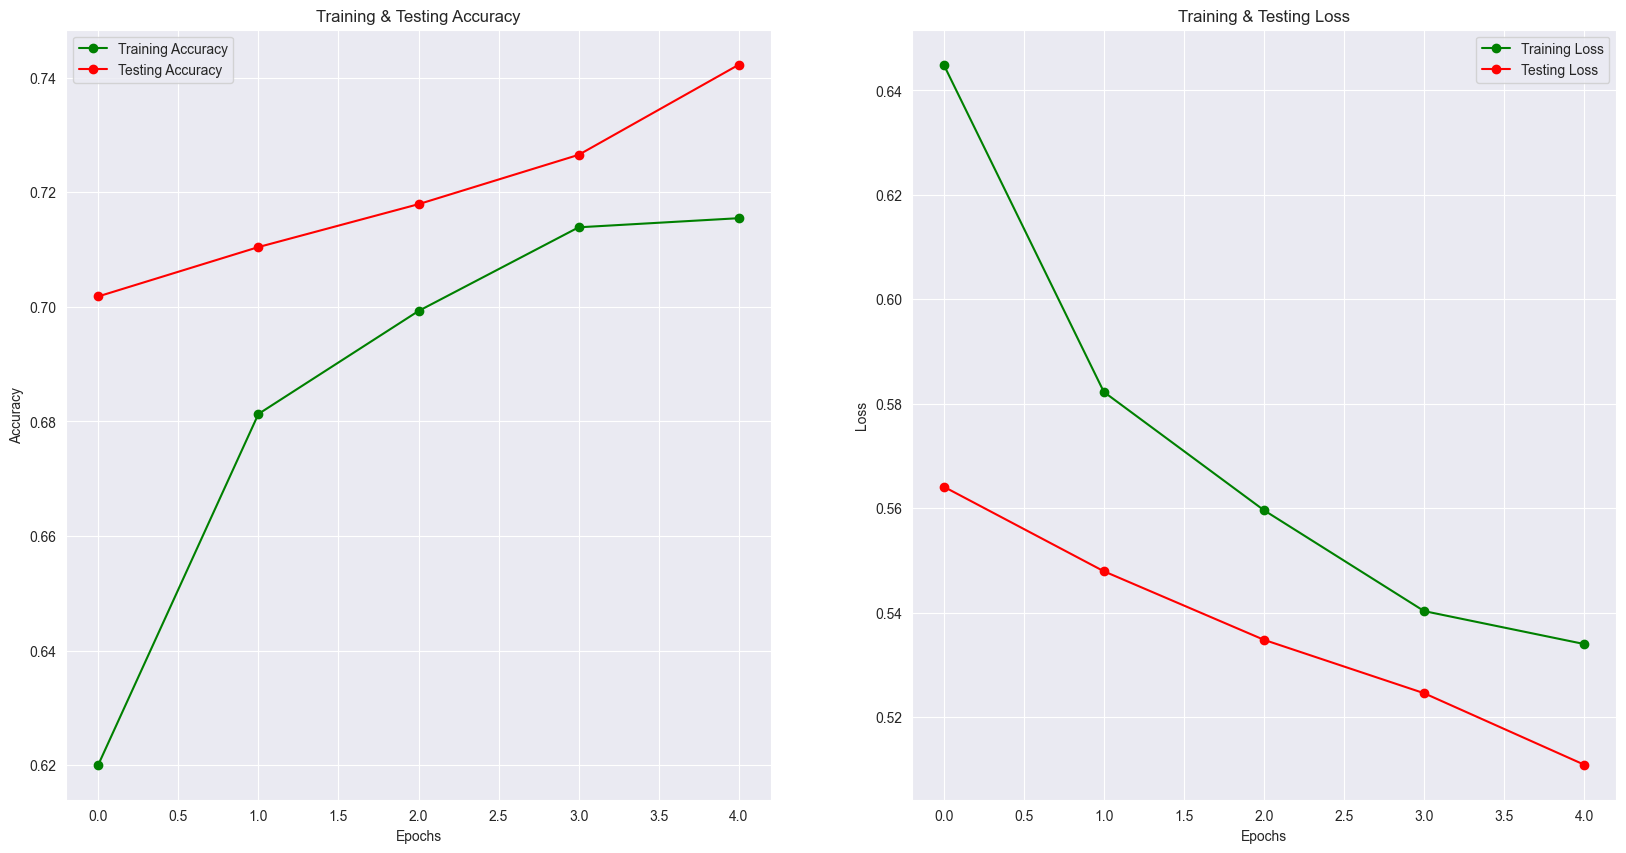

In [111]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

## Bidirectional LSTM

In [116]:
embed_size = 50
model_bidirectional = Sequential()
model_bidirectional.add(Embedding(vocab_size, embed_size, weights=[create_embeddings(embed_size, tokenizer)], trainable=False))
model_bidirectional.add(Bidirectional(LSTM(units=32, dropout=0.1, recurrent_dropout=0.3, return_sequences=False)))
model_bidirectional.add(Dense(1, activation='sigmoid'))
model_bidirectional.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=['acc', tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])

In [117]:
history_bidirectional = model_bidirectional.fit(x_train, y_train, batch_size = 128, validation_data = (x_test, y_test), epochs = 5)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - acc: 0.5941 - f1_score: 0.3916 - loss: 0.6741 - precision: 0.5530 - recall: 0.3158 - val_acc: 0.7097 - val_f1_score: 0.6955 - val_loss: 0.5580 - val_precision: 0.6447 - val_recall: 0.7549
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - acc: 0.6887 - f1_score: 0.6671 - loss: 0.5766 - precision: 0.6296 - recall: 0.7096 - val_acc: 0.7080 - val_f1_score: 0.6689 - val_loss: 0.5578 - val_precision: 0.6661 - val_recall: 0.6718
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - acc: 0.7001 - f1_score: 0.6698 - loss: 0.5650 - precision: 0.6383 - recall: 0.7048 - val_acc: 0.7235 - val_f1_score: 0.6973 - val_loss: 0.5475 - val_precision: 0.6715 - val_recall: 0.7251
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - acc: 0.7127 - f1_score: 0.6953 - loss: 0.5554 - precision: 0.6550 - recall: 0.7410 - val_acc: 0.7269 - val_f1_score: 0.7047 - val_loss: 0.5313 - val_precision: 0.6709 - val_recall: 0.7421
Epoch 5/5
167/167 ━━━━━━━━━━━━━━

In [118]:
y_pred = np.where(model_bidirectional.predict(x_test) > 0.5, 1, 0)

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [119]:
model_bidirectional.evaluate(x_test, y_test)

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.7191 - f1_score: 0.7138 - loss: 0.5370 - precision: 0.6485 - recall: 0.7939


[0.5330605506896973,
 0.722575843334198,
 0.7180364727973938,
 0.6484535932540894,
 0.804347813129425]

In [121]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.66      0.73      2996
           1       0.65      0.80      0.72      2346

    accuracy                           0.72      5342
   macro avg       0.73      0.73      0.72      5342
weighted avg       0.74      0.72      0.72      5342



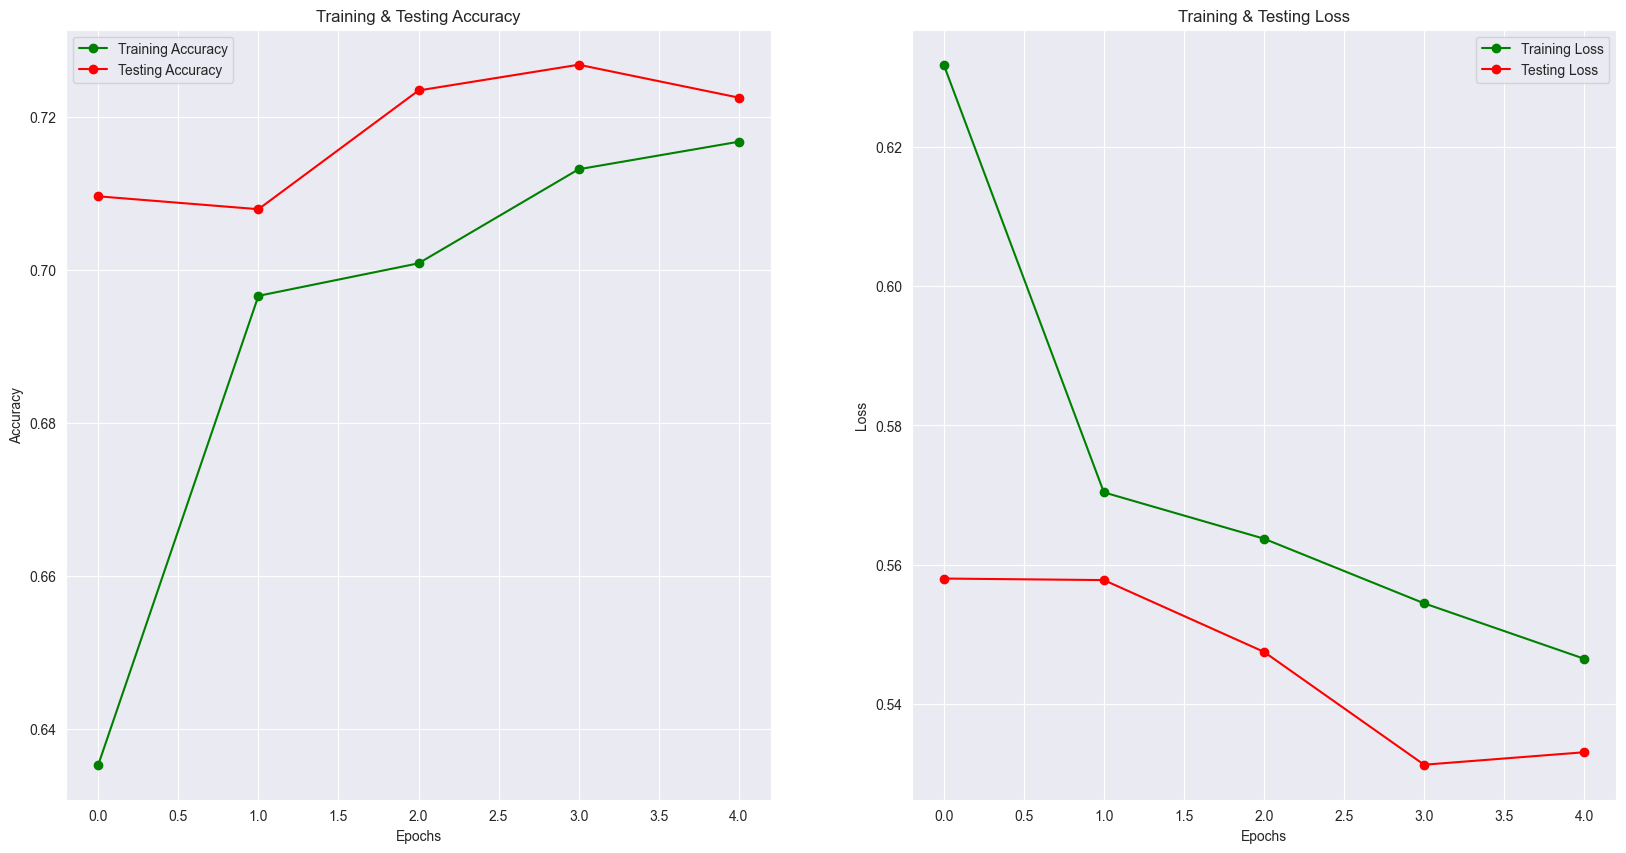

In [122]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history_bidirectional.history['acc']
train_loss = history_bidirectional.history['loss']
val_acc = history_bidirectional.history['val_acc']
val_loss = history_bidirectional.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

## Unidirectional GRU

In [129]:
embed_size = 50

model_gru = Sequential()
model_gru.add(Embedding(vocab_size, embed_size, weights=[create_embeddings(embed_size, tokenizer)], trainable=False))
model_gru.add(GRU(units=64, dropout=0.3, return_sequences=False))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc', tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])

In [130]:
history_gru = model_gru.fit(x_train, y_train, batch_size = 128, validation_data = (x_test, y_test), epochs = 5)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - acc: 0.5826 - f1_score: 0.3708 - loss: 0.6707 - precision: 0.5424 - recall: 0.2856 - val_acc: 0.6898 - val_f1_score: 0.6989 - val_loss: 0.5932 - val_precision: 0.6091 - val_recall: 0.8197
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - acc: 0.6739 - f1_score: 0.6343 - loss: 0.5921 - precision: 0.6332 - recall: 0.6360 - val_acc: 0.7171 - val_f1_score: 0.6968 - val_loss: 0.5458 - val_precision: 0.6583 - val_recall: 0.7400
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - acc: 0.6887 - f1_score: 0.6475 - loss: 0.5656 - precision: 0.6423 - recall: 0.6528 - val_acc: 0.7035 - val_f1_score: 0.7267 - val_loss: 0.5504 - val_precision: 0.6104 - val_recall: 0.8977
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - acc: 0.7061 - f1_score: 0.6753 - loss: 0.5441 - precision: 0.6536 - recall: 0.6998 - val_acc: 0.7478 - val_f1_score: 0.7344 - val_loss: 0.5076 - val_precision: 0.6833 - val_recall: 0.7937
Epoch 5/5
167/167 ━━━━━━━━━━━━━━

In [135]:
model_gru.evaluate(x_test, y_test)

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7422 - f1_score: 0.6995 - loss: 0.5141 - precision: 0.7200 - recall: 0.6803


[0.508884608745575,
 0.7442905306816101,
 0.7013553977012634,
 0.7199282050132751,
 0.6837169528007507]

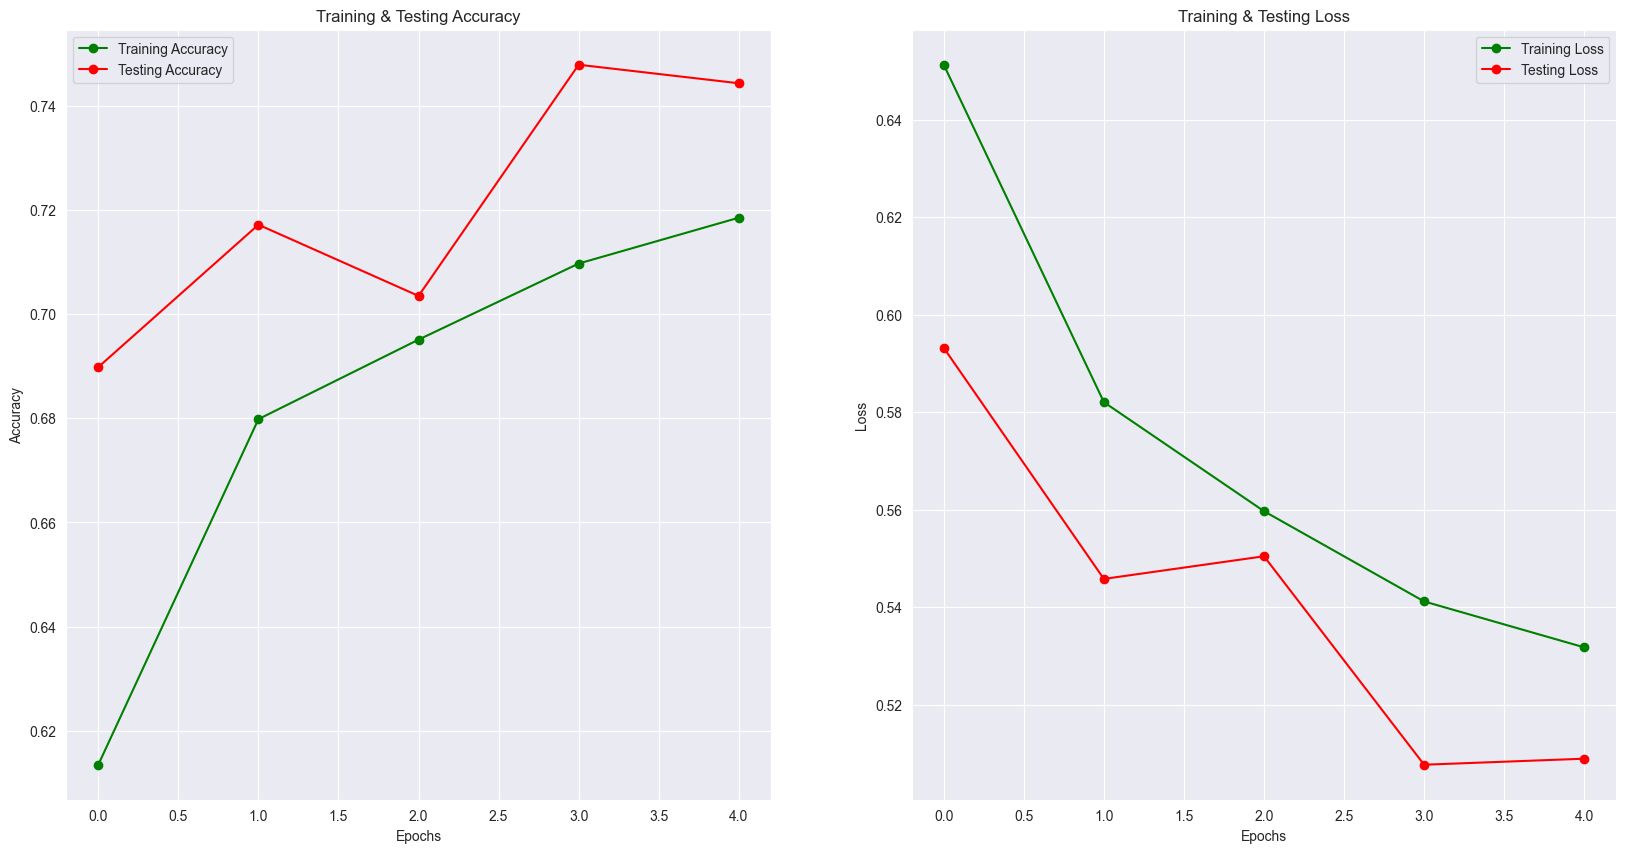

In [137]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history_gru.history['acc']
train_loss = history_gru.history['loss']
val_acc = history_gru.history['val_acc']
val_loss = history_gru.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

## Bidirectional GRU

In [138]:
embed_size = 50

model_gru_bi = Sequential()
model_gru_bi.add(Embedding(vocab_size, embed_size, weights=[create_embeddings(embed_size, tokenizer)], trainable=False))
model_gru_bi.add(Bidirectional(GRU(units=64, dropout=0.3, return_sequences=False)))
model_gru_bi.add(Dense(1, activation='sigmoid'))
model_gru_bi.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc', tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])

In [139]:
history_gru_bi = model_gru_bi.fit(x_train, y_train, batch_size = 128, validation_data = (x_test, y_test), epochs = 5)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - acc: 0.5781 - f1_score: 0.3474 - loss: 0.6710 - precision: 0.5365 - recall: 0.2624 - val_acc: 0.6984 - val_f1_score: 0.7009 - val_loss: 0.5775 - val_precision: 0.6208 - val_recall: 0.8048
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - acc: 0.6748 - f1_score: 0.6305 - loss: 0.5859 - precision: 0.6262 - recall: 0.6353 - val_acc: 0.7254 - val_f1_score: 0.6943 - val_loss: 0.5398 - val_precision: 0.6792 - val_recall: 0.7101
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - acc: 0.6955 - f1_score: 0.6605 - loss: 0.5602 - precision: 0.6493 - recall: 0.6723 - val_acc: 0.7201 - val_f1_score: 0.6779 - val_loss: 0.5341 - val_precision: 0.6854 - val_recall: 0.6705
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - acc: 0.7105 - f1_score: 0.6773 - loss: 0.5456 - precision: 0.6578 - recall: 0.6981 - val_acc: 0.7267 - val_f1_score: 0.7379 - val_loss: 0.5283 - val_precision: 0.6374 - val_recall: 0.8760
Epoch 5/5
167/167 ━━━━━━━━━━

In [143]:
model_gru_bi.evaluate(x_test, y_test)

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7422 - f1_score: 0.7072 - loss: 0.5174 - precision: 0.7087 - recall: 0.7058


[0.5109184980392456,
 0.7439161539077759,
 0.708564043045044,
 0.7082623243331909,
 0.7088661789894104]

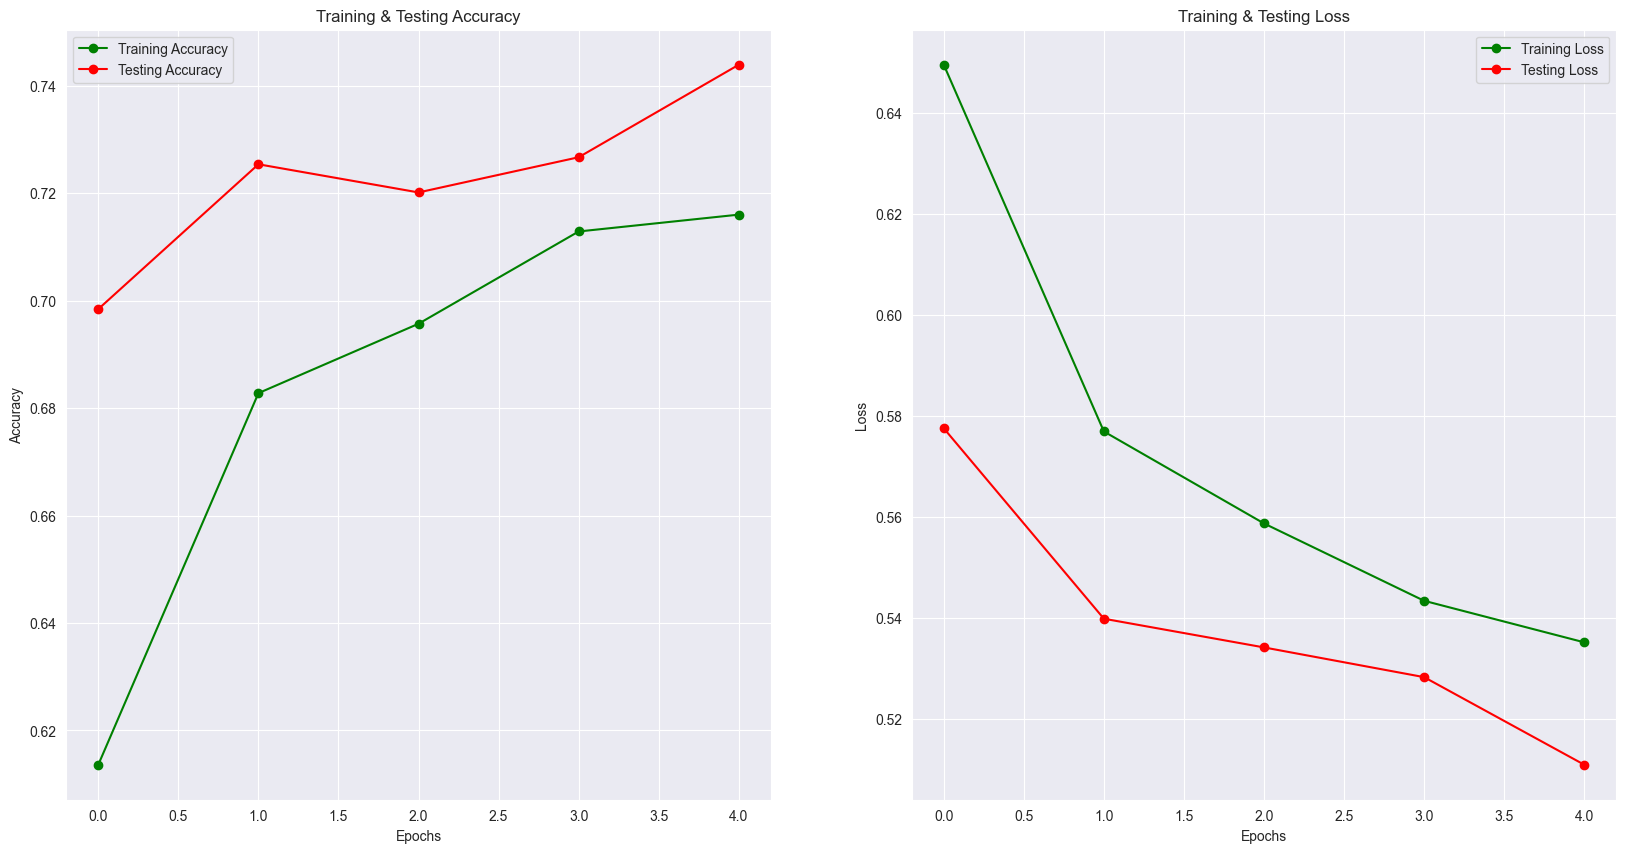

In [142]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history_gru_bi.history['acc']
train_loss = history_gru_bi.history['loss']
val_acc = history_gru_bi.history['val_acc']
val_loss = history_gru_bi.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Hyperparameter Tuning

## Keras Tuner [Archive]

In [160]:
import keras_tuner as kt

def build_model(hp):
    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = Embedding(vocab_size, embed_size, weights=[create_embeddings(embed_size, tokenizer)], trainable=False)(inp)
    x = Bidirectional(LSTM(units=hp.Int("lstm_units", 2, 128, step=2, sampling="log"), dropout=hp.Float("lstm_dropout", 0.1, 0.3, step=0.1), recurrent_dropout=hp.Float("lstm_recur_dropout", 0, 0.2, step=0.1), return_sequences=False))(x)
    x = Dense(1, activation="sigmoid")(x)
    #compiling the model
    model = tf.keras.Model(inputs=inp, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", 1e-5, 1e-2, step=10, sampling="log")),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])
    return model

In [161]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective('val_f1_score', "max"),
                     max_epochs=5,
                     factor=3,
                     directory='tuner',
                     project_name='BiLSTM')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [162]:
tuner.search(x_train,y_train,epochs=5, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

Trial 2 Complete [00h 00m 30s]
val_f1_score: 0.0031364341266453266

Best val_f1_score So Far: 0.5845561623573303
Total elapsed time: 00h 00m 58s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |4                 |lstm_units
0.1               |0.1               |lstm_dropout
0.2               |0.1               |lstm_recur_dropout
0.001             |1e-05             |lr
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
535/535 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - accuracy: 0.6263 - f1_score: 0.5303 - loss: 0.6357 - precision: 0.5923 - recall: 0.4911 - val_accuracy: 0.7377 - val_f1_score: 0.7400 - val_loss: 0.5194 - val_precision: 0.6635 - val_recall: 0.8364
Epoch 2/2
529/535 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6976 - f1_score: 0.6576 - loss: 0.5586 - preci

KeyboardInterrupt: 

## Optuna
This was run offline on Google Colab to use the GPU for training. The following hyperparameters were selected:


In [25]:
import optuna

def create_model(trial):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_size, weights=[create_embeddings(embed_size, tokenizer)], trainable=False))
    lstm_units = trial.suggest_int("lstm_units", 2, 128, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    recurrent_dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    model.add(Bidirectional(LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate, return_sequences=False)))
    model.add(Dense(1, activation='sigmoid'))
    return model

EPOCHS = 5
def objective(trial):
    # Build model and optimizer.
    model = create_model(trial)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['acc',
                                                                                                                tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])
    model.fit(x_train, y_train, batch_size = 128, epochs = EPOCHS, verbose = 0)
    return model.evaluate(x_test, y_test)[2]

In [26]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2025-04-05 23:52:33,896] A new study created in memory with name: no-name-3fb995c4-0869-4dc7-9787-cd0189e794dd


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.6848 - f1_score: 0.6882 - loss: 0.5841 - precision: 0.6106 - recall: 0.7886


[I 2025-04-05 23:54:07,016] Trial 0 finished with value: 0.6898966431617737 and parameters: {'lstm_units': 88, 'dropout_rate': 0.5, 'lr': 0.01619679686757301}. Best is trial 0 with value: 0.6898966431617737.
[W 2025-04-05 23:54:32,151] Trial 1 failed with parameters: {'lstm_units': 66, 'dropout_rate': 0.5, 'lr': 6.813734808239314e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/vigne/Desktop/NUS/y4s2/cs4248/files/project/CS4248_Group8_SarcasmDetection/.venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/q0/p7qy8s8d0314lj9p2snkpr940000gn/T/ipykernel_4761/1870087771.py", line 20, in objective
    model.fit(x_train, y_train, batch_size = 128, epochs = EPOCHS, verbose = 0)
  File "/Users/vigne/Desktop/NUS/y4s2/cs4248/files/project/CS4248_Group8_SarcasmDetection/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in e

KeyboardInterrupt: 

# Ensemble Models

## Stacked LSTM Model

In [165]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, df['is_sarcastic'], test_size=0.2, random_state=42)

In [168]:
model_stacked = Sequential()
model_stacked.add(Embedding(vocab_size, embed_size, weights=[create_embeddings(embed_size, tokenizer)], trainable=False))
model_stacked.add(Bidirectional(LSTM(units=128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)))
model_stacked.add(Bidirectional(LSTM(units=64, dropout=0.1, recurrent_dropout=0.1, return_sequences=False)))
model_stacked.add(Dense(1, activation='sigmoid'))
model_stacked.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['acc',
                                                                                                                tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])

In [169]:
history = model_stacked.fit(x_train1, y_train1, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 50s 282ms/step - acc: 0.6451 - f1_score: 0.5393 - loss: 0.6326 - precision: 0.6162 - recall: 0.5040
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 61s 366ms/step - acc: 0.7150 - f1_score: 0.6989 - loss: 0.5387 - precision: 0.6605 - recall: 0.7424
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 63s 377ms/step - acc: 0.7331 - f1_score: 0.7098 - loss: 0.5120 - precision: 0.6798 - recall: 0.7434
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 64s 381ms/step - acc: 0.7475 - f1_score: 0.7252 - loss: 0.4956 - precision: 0.6920 - recall: 0.7620
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 63s 375ms/step - acc: 0.7517 - f1_score: 0.7262 - loss: 0.4903 - precision: 0.7024 - recall: 0.7518


In [171]:
model_stacked.evaluate(x_test1, y_test1)

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - acc: 0.7684 - f1_score: 0.7672 - loss: 0.4808 - precision: 0.6895 - recall: 0.8650


[0.4803197681903839,
 0.7622613310813904,
 0.7609185576438904,
 0.6813890933990479,
 0.8614663481712341]

In [172]:
y_pred = np.where(model_stacked.predict(x_test1) > 0.5, 1, 0)
print(classification_report(y_test1, y_pred))

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
              precision    recall  f1-score   support

           0       0.86      0.68      0.76      2996
           1       0.68      0.86      0.76      2346

    accuracy                           0.76      5342
   macro avg       0.77      0.77      0.76      5342
weighted avg       0.78      0.76      0.76      5342



## Kaggle LSTM + GRU Model

In [179]:
model_kaggle = Sequential()
model_kaggle.add(Embedding(vocab_size, 200, weights=[create_embeddings(200, tokenizer)], trainable=False))
model_kaggle.add(Bidirectional(LSTM(units=128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model_kaggle.add(Bidirectional(GRU(units=32, dropout=0.1, recurrent_dropout=0.1, return_sequences=False)))
model_kaggle.add(Dense(1, activation='sigmoid'))
model_kaggle.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc',
                                                                                                                tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])

In [180]:
history = model_kaggle.fit(x_train1, y_train1, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 42s 235ms/step - acc: 0.6037 - f1_score: 0.4431 - loss: 0.6530 - precision: 0.5647 - recall: 0.3769
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 54s 323ms/step - acc: 0.6842 - f1_score: 0.6358 - loss: 0.5864 - precision: 0.6427 - recall: 0.6302
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - acc: 0.7095 - f1_score: 0.6852 - loss: 0.5435 - precision: 0.6580 - recall: 0.7152
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 54s 323ms/step - acc: 0.7144 - f1_score: 0.6830 - loss: 0.5349 - precision: 0.6610 - recall: 0.7071
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 55s 331ms/step - acc: 0.7331 - f1_score: 0.7101 - loss: 0.5155 - precision: 0.6769 - recall: 0.7472


In [181]:
model_kaggle.evaluate(x_test1, y_test1)

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - acc: 0.7612 - f1_score: 0.7546 - loss: 0.4944 - precision: 0.6903 - recall: 0.8324


[0.49300166964530945,
 0.7585173845291138,
 0.752208948135376,
 0.6846153736114502,
 0.8346121311187744]

In [182]:
y_pred = np.where(model_kaggle.predict(x_test1) > 0.5, 1, 0)
print(classification_report(y_test1, y_pred))

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step
              precision    recall  f1-score   support

           0       0.84      0.70      0.76      2996
           1       0.68      0.83      0.75      2346

    accuracy                           0.76      5342
   macro avg       0.76      0.77      0.76      5342
weighted avg       0.77      0.76      0.76      5342



## Numeric Features (Concat + Dense)

In [51]:
 df2 = pd.read_csv('data/selected_train.csv')

In [52]:
print(df2.shape)
df2.head()

(26709, 11)


,is_sarcastic,num_words_vs_length,length_vs_num_words_scaled,num_stopwords_scaled,stopwords_vs_length,stopwords_vs_words,num_question_marks,question_vs_length,question_vs_words,unique_vs_words,readability_scaled
0,0,0.153846,0.272200,-0.456474,0.025641,0.166667,0,0.0,0.0,1.000000,-0.275838
1,0,0.166667,-0.229869,1.603328,0.071429,0.428571,0,0.0,0.0,1.000000,0.165303
2,1,0.177215,-0.588490,1.088377,0.063291,0.357143,0,0.0,0.0,0.857143,0.430402
3,1,0.154762,0.233579,1.088377,0.059524,0.384615,0,0.0,0.0,1.000000,-0.099795
4,0,0.171875,-0.412440,0.058476,0.046875,0.272727,0,0.0,0.0,1.000000,0.519690


In [53]:
df_combined = pd.merge(pd.DataFrame(x), df2, on=df2.index).drop(['is_sarcastic', 'key_0'], axis=1)

In [126]:
print(df_combined.shape)
df_combined.head()

(26709, 60)


,0,1,2,3,4,5,6,7,8,9,...,num_words_vs_length,length_vs_num_words_scaled,num_stopwords_scaled,stopwords_vs_length,stopwords_vs_words,num_question_marks,question_vs_length,question_vs_words,unique_vs_words,readability_scaled
0,0,0,0,0,0,0,0,0,0,0,...,0.153846,0.272200,-0.456474,0.025641,0.166667,0,0.0,0.0,1.000000,-0.275838
1,0,0,0,0,0,0,0,0,0,0,...,0.166667,-0.229869,1.603328,0.071429,0.428571,0,0.0,0.0,1.000000,0.165303
2,0,0,0,0,0,0,0,0,0,0,...,0.177215,-0.588490,1.088377,0.063291,0.357143,0,0.0,0.0,0.857143,0.430402
3,0,0,0,0,0,0,0,0,0,0,...,0.154762,0.233579,1.088377,0.059524,0.384615,0,0.0,0.0,1.000000,-0.099795
4,0,0,0,0,0,0,0,0,0,0,...,0.171875,-0.412440,0.058476,0.046875,0.272727,0,0.0,0.0,1.000000,0.519690


In [154]:
def make_model():
    # Input 1: text
    inp1 = tf.keras.layers.Input(shape=(maxlen,))
    x1 = Embedding(vocab_size, embed_size, weights=[create_embeddings(embed_size, tokenizer)], trainable=False)(inp1)
    x1 = Bidirectional(LSTM(units=128, dropout=0.1, recurrent_dropout=0.1, return_sequences=False))(x1)

    # Input 2: hand-crafted features
    inp2 = tf.keras.layers.Input(shape=(10,))

    # Merging both feature paths
    x = tf.keras.layers.Concatenate()([x1, inp2])
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=[inp1, inp2], outputs=x)
    return model


In [155]:
model = make_model()
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['acc',
                                                                                                                tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])

In [156]:
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_20        │ (None, 50, 50)    │  1,416,900 │ input_layer_30[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_20    │ (None, 256)       │    183,296 │ embedding_20[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_31      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 266)       │          0 │ bidirectional_20… │
│ (Concatenate)       │                   │            │ input_layer_31[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 64)        │     17,088 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 1)         │         65 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,617,349 (6.17 MB)

 Trainable params: 200,449 (783.00 KB)

 Non-trainable params: 1,416,900 (5.41 MB)

In [157]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_combined, df['is_sarcastic'], test_size=0.2)
history = model.fit([x_train.iloc[:, :50], x_train.iloc[:, 50:]], y_train,
                    validation_data = ([x_test.iloc[:, :50], x_test.iloc[:, 50:]], y_test),
                    batch_size = 128, epochs = 5, verbose = 1)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - acc: 0.6321 - f1_score: 0.5714 - loss: 0.6272 - precision: 0.5872 - recall: 0.5595 - val_acc: 0.7340 - val_f1_score: 0.7436 - val_loss: 0.5195 - val_precision: 0.6510 - val_recall: 0.8671
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - acc: 0.7234 - f1_score: 0.6992 - loss: 0.5247 - precision: 0.6620 - recall: 0.7414 - val_acc: 0.7548 - val_f1_score: 0.7265 - val_loss: 0.5014 - val_precision: 0.7211 - val_recall: 0.7320
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 33s 199ms/step - acc: 0.7485 - f1_score: 0.7261 - loss: 0.4999 - precision: 0.7042 - recall: 0.7496 - val_acc: 0.7623 - val_f1_score: 0.7272 - val_loss: 0.4855 - val_precision: 0.7429 - val_recall: 0.7122
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - acc: 0.7579 - f1_score: 0.7307 - loss: 0.4795 - precision: 0.7098 - recall: 0.7530 - val_acc: 0.7690 - val_f1_score: 0.7506 - val_loss: 0.4733 - val_precision: 0.7223 - val_recall: 0.7812
Epoch 5/5
167/167 ━━━━━━

In [162]:
model.evaluate([x_test.iloc[:, :50], x_test.iloc[:, 50:]], y_test)

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.7655 - f1_score: 0.7455 - loss: 0.4674 - precision: 0.7112 - recall: 0.7836


[0.46702587604522705,
 0.7658180594444275,
 0.7529131770133972,
 0.70960533618927,
 0.8018510937690735]

In [163]:
y_pred = np.where(model.predict([x_test.iloc[:, :50], x_test.iloc[:, 50:]], verbose=0) > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      2965
           1       0.71      0.80      0.75      2377

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



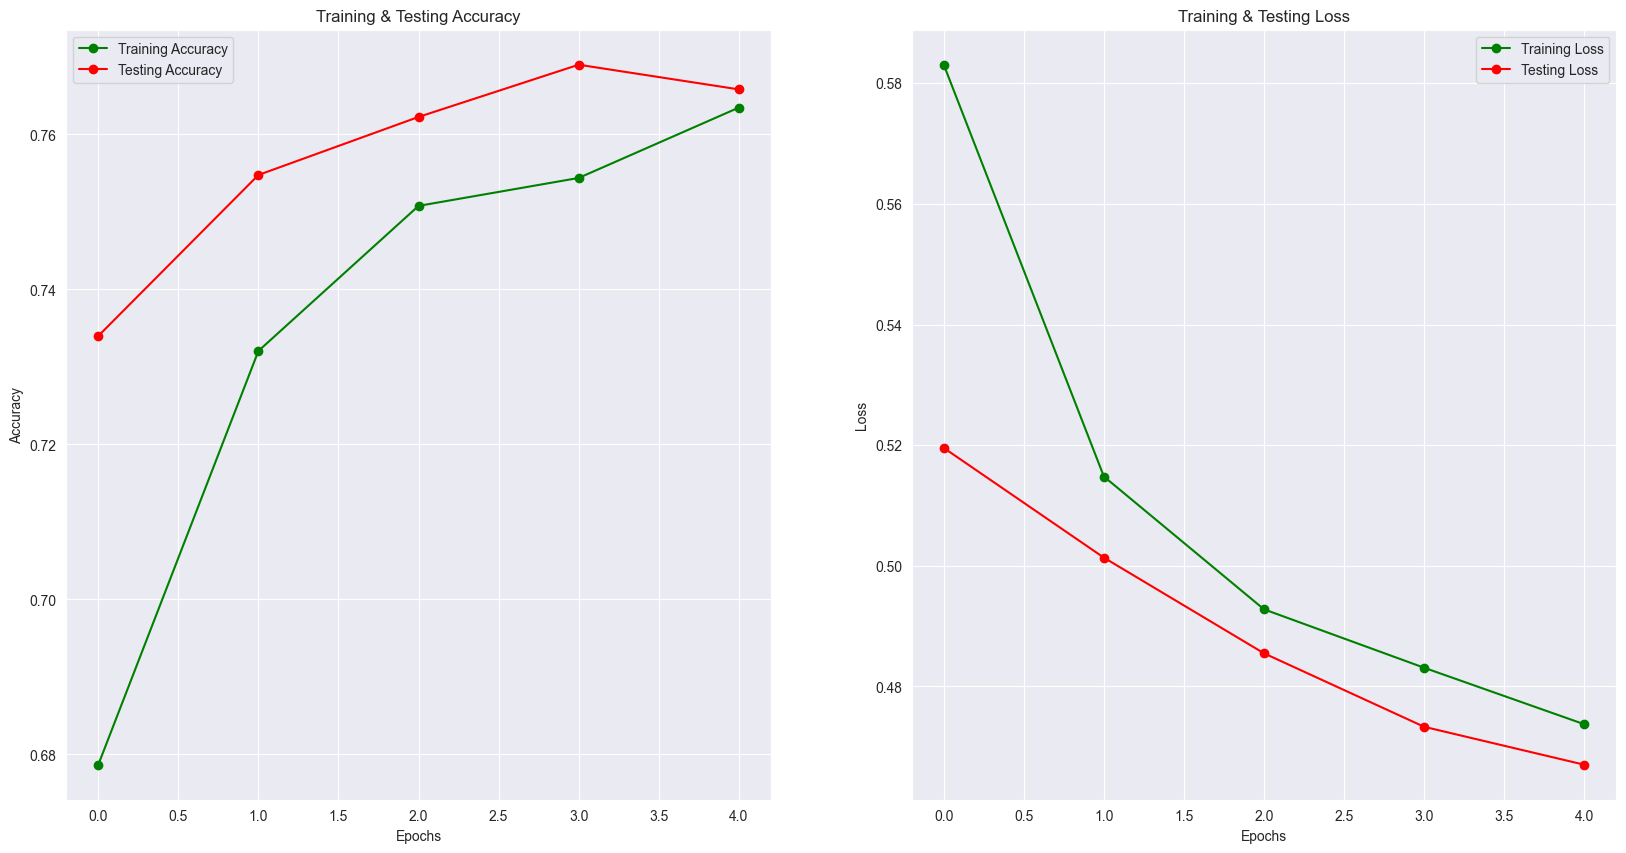

In [164]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [183]:
def make_model2():
    # Input 1: text
    inp1 = tf.keras.layers.Input(shape=(maxlen,))
    x1 = Embedding(vocab_size, embed_size, weights=[create_embeddings(embed_size, tokenizer)], trainable=False)(inp1)
    x1 = Bidirectional(LSTM(units=128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))(x1)
    x1 = Bidirectional(LSTM(units=64, dropout=0.1, recurrent_dropout=0.1, return_sequences=False))(x1)

    # Input 2: hand-crafted features
    inp2 = tf.keras.layers.Input(shape=(10,))

    # Merging both feature paths
    x = tf.keras.layers.Concatenate()([x1, inp2])
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=[inp1, inp2], outputs=x)
    return model

In [185]:
model2 = make_model2()
model2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['acc',
                                                                                                                tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])
history = model2.fit([x_train.iloc[:, :50], x_train.iloc[:, 50:]], y_train,
                    validation_data = ([x_test.iloc[:, :50], x_test.iloc[:, 50:]], y_test),
                    batch_size = 128, epochs = 5, verbose = 1)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 294ms/step - acc: 0.6321 - f1_score: 0.5531 - loss: 0.6257 - precision: 0.5834 - recall: 0.5295 - val_acc: 0.7480 - val_f1_score: 0.7376 - val_loss: 0.5037 - val_precision: 0.6873 - val_recall: 0.7960
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 63s 378ms/step - acc: 0.7295 - f1_score: 0.7123 - loss: 0.5240 - precision: 0.6694 - recall: 0.7611 - val_acc: 0.7565 - val_f1_score: 0.7372 - val_loss: 0.4868 - val_precision: 0.7090 - val_recall: 0.7678
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 65s 388ms/step - acc: 0.7449 - f1_score: 0.7202 - loss: 0.5005 - precision: 0.6949 - recall: 0.7476 - val_acc: 0.7683 - val_f1_score: 0.7507 - val_loss: 0.4735 - val_precision: 0.7200 - val_recall: 0.7842
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 65s 391ms/step - acc: 0.7542 - f1_score: 0.7303 - loss: 0.4841 - precision: 0.7050 - recall: 0.7576 - val_acc: 0.7697 - val_f1_score: 0.7561 - val_loss: 0.4692 - val_precision: 0.7150 - val_recall: 0.8023
Epoch 5/5
167/167 ━━━━━━

In [188]:
model2.evaluate([x_test.iloc[:, :50], x_test.iloc[:, 50:]], y_test)

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - acc: 0.7670 - f1_score: 0.7589 - loss: 0.4774 - precision: 0.6953 - recall: 0.8359


[0.47649261355400085,
 0.7688131928443909,
 0.7652537822723389,
 0.6979889273643494,
 0.8468657732009888]

In [190]:
y_pred = np.where(model2.predict([x_test.iloc[:, :50], x_test.iloc[:, 50:]], verbose=0) > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.71      0.77      2965
           1       0.70      0.85      0.77      2377

    accuracy                           0.77      5342
   macro avg       0.77      0.78      0.77      5342
weighted avg       0.78      0.77      0.77      5342



# Consolidated Results (Word2Vec + Handcrafted Features)
| Model                                     | Acc  | F1   | Prec | Recall |
|-------------------------------------------|------|------|------|--------|
| Bidirectional LSTM (Base)                 | 0.75 | 0.75 | 0.65 | 0.80   |
| Stacked Bidirectional LSTM                | 0.76 | 0.76 | 0.68 | 0.86   |
| Bidirectional LSTM + GRU (Kaggle)         | 0.75 | 0.75 | 0.68 | 0.83   |
| Bidirectional LSTM + Handcrafted Features | 0.77 | 0.75 | 0.71 | 0.80   |
| Stacked BiLSTM + HF                       | 0.77 | 0.77 | 0.70 | 0.85   |


# GloVe Embedding Model

In [21]:
glove_dict = {}
with open('embeddings/glove.6B.50d.txt') as f:
    for line in f:
        vec = line.split()
        word, vec = vec[0], list(map(float, vec[1:]))
        glove_dict[word] = np.array(vec)

In [22]:
glove_model = {}
for word in words:
    glove_model[word] = glove_dict.get(word, np.zeros(50))

In [23]:
def get_weight_mat(model, vocab):
    vocab_size = len(vocab) + 1 #for unknown words
    weights = np.zeros((vocab_size, embed_size))
    for word, i in vocab.items():
        weights[i] = model[word]
    return weights

In [35]:
embed_size = 50
model_bidirectional = Sequential()
model_bidirectional.add(Embedding(len(glove_model) + 1, embed_size, weights=[get_weight_mat(glove_model, tokenizer.word_index)], trainable=False))
model_bidirectional.add(Bidirectional(LSTM(units=128, dropout=0.1, recurrent_dropout=0.1, return_sequences=False)))
model_bidirectional.add(Dense(1, activation='sigmoid'))
model_bidirectional.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc', tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, df['is_sarcastic'], test_size=0.2, random_state=42)

In [36]:
history = model_bidirectional.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 64s 93ms/step - acc: 0.6656 - f1_score: 0.5430 - loss: 0.6064 - precision: 0.6517 - recall: 0.4734 - val_acc: 0.7645 - val_f1_score: 0.6836 - val_loss: 0.4906 - val_precision: 0.8337 - val_recall: 0.5793
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step - acc: 0.7892 - f1_score: 0.7550 - loss: 0.4556 - precision: 0.7749 - recall: 0.7365 - val_acc: 0.8132 - val_f1_score: 0.7787 - val_loss: 0.4020 - val_precision: 0.8115 - val_recall: 0.7485
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 68s 102ms/step - acc: 0.8178 - f1_score: 0.7892 - loss: 0.4032 - precision: 0.8044 - recall: 0.7748 - val_acc: 0.8323 - val_f1_score: 0.8007 - val_loss: 0.3718 - val_precision: 0.8372 - val_recall: 0.7673
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 69s 104ms/step - acc: 0.8394 - f1_score: 0.8165 - loss: 0.3574 - precision: 0.8244 - recall: 0.8090 - val_acc: 0.8385 - val_f1_score: 0.8222 - val_loss: 0.3696 - val_precision: 0.7958 - val_recall: 0.8504
Epoch 5/5
668/668 ━━━━━━━

In [37]:
model_bidirectional.evaluate(x_test, y_test)

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.8325 - f1_score: 0.7880 - loss: 0.3786 - precision: 0.8911 - recall: 0.7065


[0.38857904076576233,
 0.8318981528282166,
 0.7864954471588135,
 0.8892472982406616,
 0.7050298452377319]

In [38]:
from sklearn.metrics import classification_report
y_pred = np.where(model_bidirectional.predict(x_test) > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2996
           1       0.89      0.71      0.79      2346

    accuracy                           0.83      5342
   macro avg       0.85      0.82      0.82      5342
weighted avg       0.84      0.83      0.83      5342



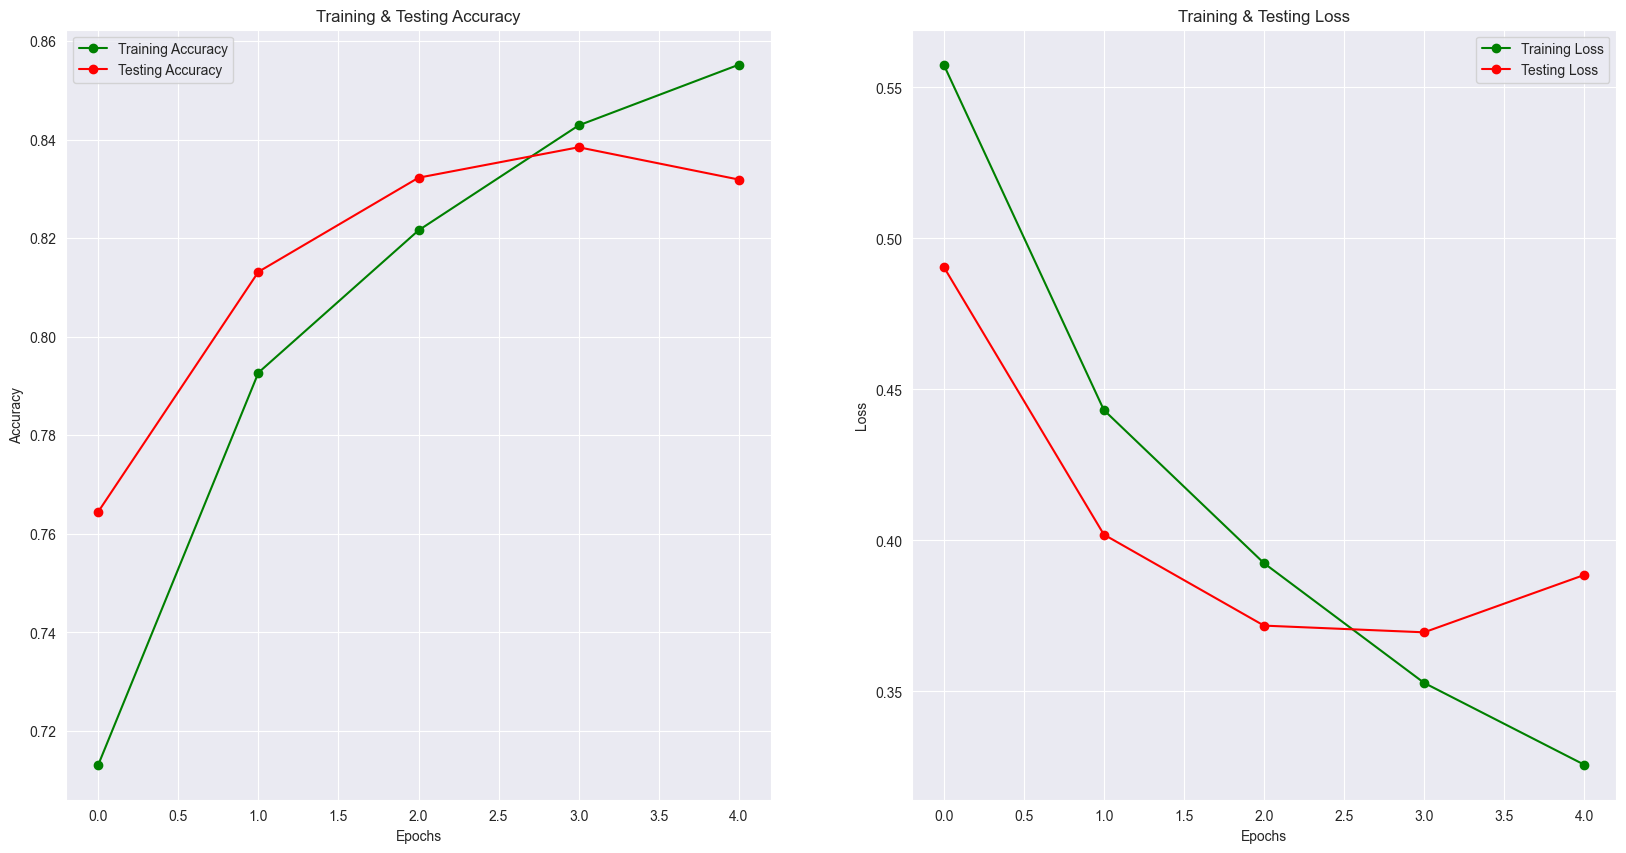

In [39]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [42]:
model_stacked = Sequential()
model_stacked.add(Embedding(len(glove_model) + 1, embed_size, weights=[get_weight_mat(glove_model, tokenizer.word_index)], trainable=False))
model_stacked.add(Bidirectional(LSTM(units=128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)))
model_stacked.add(Bidirectional(LSTM(units=64, dropout=0.1, recurrent_dropout=0.1, return_sequences=False)))
model_stacked.add(Dense(1, activation='sigmoid'))
model_stacked.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['acc',
                                                                                                                tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])

In [43]:
history = model_stacked.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - acc: 0.6536 - f1_score: 0.5601 - loss: 0.6194 - precision: 0.6324 - recall: 0.5055 - val_acc: 0.7993 - val_f1_score: 0.7712 - val_loss: 0.4301 - val_precision: 0.7722 - val_recall: 0.7702
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 125s 187ms/step - acc: 0.8159 - f1_score: 0.7913 - loss: 0.4113 - precision: 0.7910 - recall: 0.7917 - val_acc: 0.8278 - val_f1_score: 0.8188 - val_loss: 0.4044 - val_precision: 0.7612 - val_recall: 0.8858
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 124s 186ms/step - acc: 0.8566 - f1_score: 0.8374 - loss: 0.3363 - precision: 0.8334 - recall: 0.8414 - val_acc: 0.8407 - val_f1_score: 0.8313 - val_loss: 0.3577 - val_precision: 0.7770 - val_recall: 0.8939
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 127s 191ms/step - acc: 0.8791 - f1_score: 0.8617 - loss: 0.2854 - precision: 0.8609 - recall: 0.8626 - val_acc: 0.8493 - val_f1_score: 0.8274 - val_loss: 0.3508 - val_precision: 0.8325 - val_recall: 0.8223
Epoch 5/5
668/668 ━━

In [44]:
model_stacked.evaluate(x_test, y_test)

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - acc: 0.8517 - f1_score: 0.8256 - loss: 0.3421 - precision: 0.8574 - recall: 0.7963


[0.34678226709365845,
 0.8526769280433655,
 0.8274500966072083,
 0.8519187569618225,
 0.804347813129425]

In [46]:
y_pred = np.where(model_stacked.predict(x_test) > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2996
           1       0.85      0.80      0.83      2346

    accuracy                           0.85      5342
   macro avg       0.85      0.85      0.85      5342
weighted avg       0.85      0.85      0.85      5342



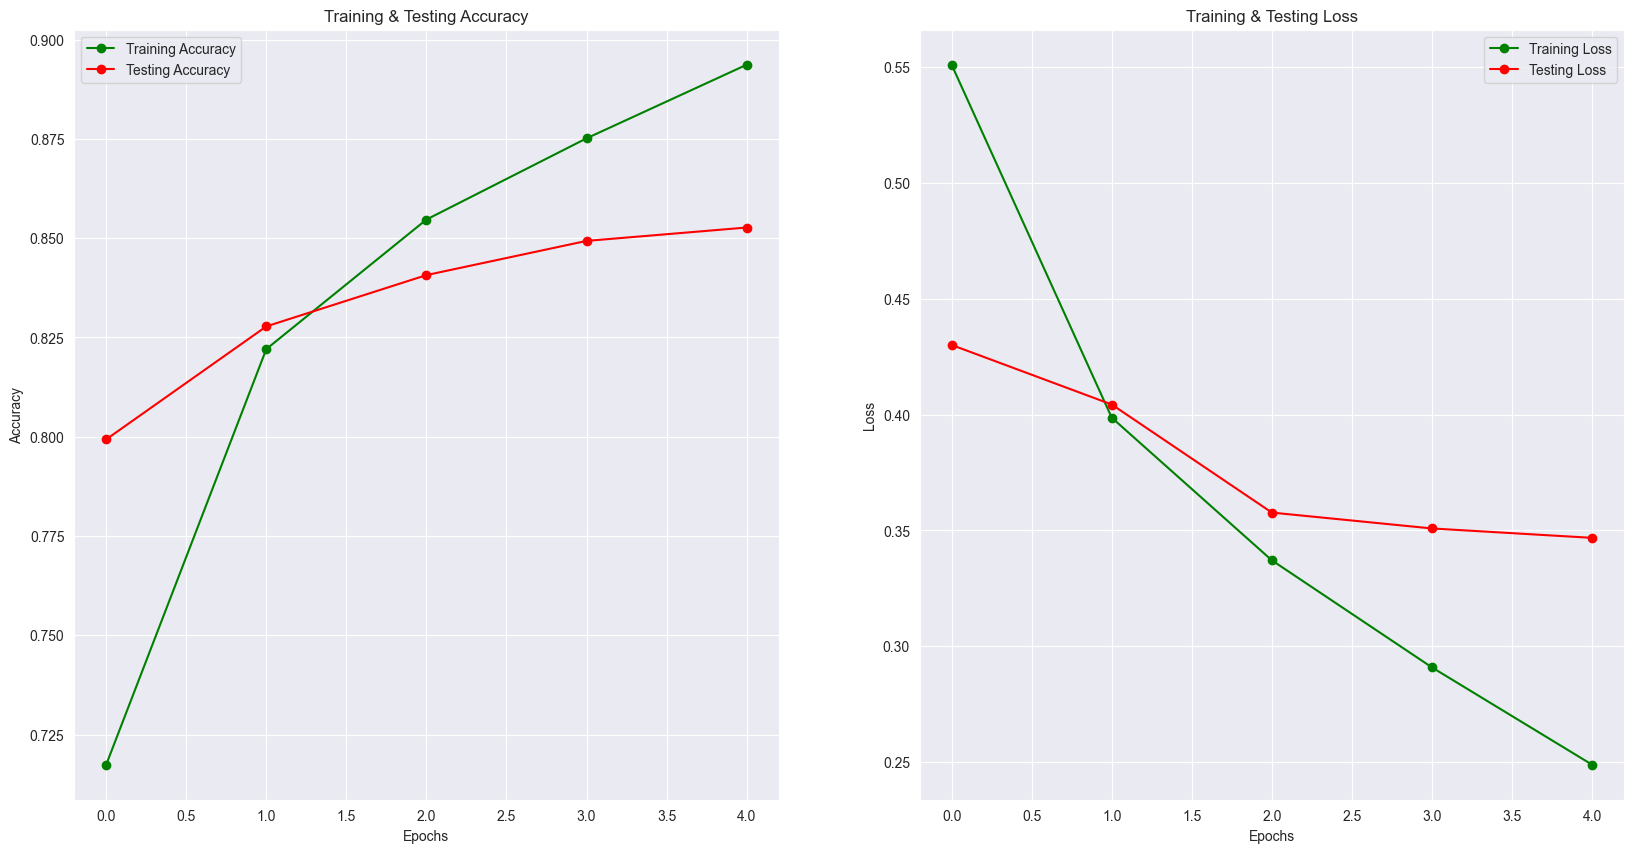

In [48]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [50]:
def make_model():
    # Input 1: text
    inp1 = tf.keras.layers.Input(shape=(maxlen,))
    x1 = Embedding(len(glove_model) + 1, embed_size, weights=[get_weight_mat(glove_model, tokenizer.word_index)], trainable=False)(inp1)
    x1 = Bidirectional(LSTM(units=128, dropout=0.1, recurrent_dropout=0.1, return_sequences=False))(x1)

    # Input 2: hand-crafted features
    inp2 = tf.keras.layers.Input(shape=(10,))

    # Merging both feature paths
    x = tf.keras.layers.Concatenate()([x1, inp2])
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=[inp1, inp2], outputs=x)
    return model

model = make_model()
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['acc',
                                                                                                                tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])

In [54]:
x_trainc, x_testc, y_trainc, y_testc = train_test_split(df_combined, df['is_sarcastic'], test_size=0.2)

In [60]:
history = model.fit([x_trainc.iloc[:, :50], x_trainc.iloc[:, 50:]], y_trainc,
                    validation_data = ([x_testc.iloc[:, :50], x_testc.iloc[:, 50:]], y_testc),
                    batch_size = 128, epochs = 3, verbose = 1)

Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - acc: 0.6832 - f1_score: 0.6006 - loss: 0.5854 - precision: 0.6545 - recall: 0.5589 - val_acc: 0.7995 - val_f1_score: 0.7593 - val_loss: 0.4293 - val_precision: 0.7926 - val_recall: 0.7286
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 33s 196ms/step - acc: 0.8157 - f1_score: 0.7845 - loss: 0.4057 - precision: 0.8001 - recall: 0.7696 - val_acc: 0.8272 - val_f1_score: 0.7926 - val_loss: 0.3802 - val_precision: 0.8270 - val_recall: 0.7610
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - acc: 0.8508 - f1_score: 0.8290 - loss: 0.3392 - precision: 0.8370 - recall: 0.8212 - val_acc: 0.8429 - val_f1_score: 0.8116 - val_loss: 0.3632 - val_precision: 0.8464 - val_recall: 0.7796


In [62]:
model.evaluate([x_testc.iloc[:, :50], x_testc.iloc[:, 50:]], y_testc)

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.8453 - f1_score: 0.8166 - loss: 0.3629 - precision: 0.8556 - recall: 0.7811


[0.3632202744483948,
 0.8429427146911621,
 0.8115876317024231,
 0.8463700413703918,
 0.7795513272285461]

In [63]:
y_pred = np.where(model.predict([x_testc.iloc[:, :50], x_testc.iloc[:, 50:]]) > 0.5, 1, 0)
print(classification_report(y_testc, y_pred))

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      3024
           1       0.85      0.78      0.81      2318

    accuracy                           0.84      5342
   macro avg       0.84      0.84      0.84      5342
weighted avg       0.84      0.84      0.84      5342



In [64]:
def make_model2():
    # Input 1: text
    inp1 = tf.keras.layers.Input(shape=(maxlen,))
    x1 = Embedding(len(glove_model) + 1, embed_size, weights=[get_weight_mat(glove_model, tokenizer.word_index)], trainable=False)(inp1)
    x1 = Bidirectional(LSTM(units=128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))(x1)
    x1 = Bidirectional(LSTM(units=64, dropout=0.1, recurrent_dropout=0.1, return_sequences=False))(x1)

    # Input 2: hand-crafted features
    inp2 = tf.keras.layers.Input(shape=(10,))

    # Merging both feature paths
    x = tf.keras.layers.Concatenate()([x1, inp2])
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=[inp1, inp2], outputs=x)
    return model

In [65]:
model2 = make_model2()
model2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['acc',
                                                                                                                tf.keras.metrics.F1Score(threshold=0.5), 'precision', 'recall'])

In [66]:
history = model2.fit([x_trainc.iloc[:, :50], x_trainc.iloc[:, 50:]], y_trainc,
                    validation_data = ([x_testc.iloc[:, :50], x_testc.iloc[:, 50:]], y_testc),
                    batch_size = 128, epochs = 3, verbose = 1)

Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 56s 310ms/step - acc: 0.6847 - f1_score: 0.6248 - loss: 0.5841 - precision: 0.6637 - recall: 0.5909 - val_acc: 0.7873 - val_f1_score: 0.7620 - val_loss: 0.4541 - val_precision: 0.7406 - val_recall: 0.7847
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 66s 398ms/step - acc: 0.8167 - f1_score: 0.7904 - loss: 0.4120 - precision: 0.7998 - recall: 0.7814 - val_acc: 0.8049 - val_f1_score: 0.7377 - val_loss: 0.4264 - val_precision: 0.8857 - val_recall: 0.6320
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 68s 409ms/step - acc: 0.8466 - f1_score: 0.8246 - loss: 0.3513 - precision: 0.8316 - recall: 0.8181 - val_acc: 0.8516 - val_f1_score: 0.8251 - val_loss: 0.3480 - val_precision: 0.8442 - val_recall: 0.8067


In [67]:
model2.evaluate([x_testc.iloc[:, :50], x_testc.iloc[:, 50:]], y_testc)

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - acc: 0.8499 - f1_score: 0.8253 - loss: 0.3502 - precision: 0.8479 - recall: 0.8040


[0.34797370433807373,
 0.851553738117218,
 0.8250606060028076,
 0.8442437648773193,
 0.8067299127578735]

In [68]:
y_pred = np.where(model2.predict([x_testc.iloc[:, :50], x_testc.iloc[:, 50:]]) > 0.5, 1, 0)
print(classification_report(y_testc, y_pred))

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3024
           1       0.84      0.81      0.83      2318

    accuracy                           0.85      5342
   macro avg       0.85      0.85      0.85      5342
weighted avg       0.85      0.85      0.85      5342



# Consolidated Results (GloVe + Handcrafted Features)
| Model                                     | Acc  | F1   | Prec | Recall |
|-------------------------------------------|------|------|------|--------|
| Bidirectional LSTM (Base)                 | 0.83 | 0.79 | 0.89 | 0.71   |
| Stacked Bidirectional LSTM                | 0.85 | 0.83 | 0.85 | 0.80   |
| Bidirectional LSTM + Handcrafted Features | 0.84 | 0.81 | 0.85 | 0.78   |
| Stacked BiLSTM + HF                       | 0.85 | 0.83 | 0.84  | 0.81   |
